# 1. Setup

df is a dataframe with the orginial text of tweets aggregated on a daily basis.

t is a list object in python where NLPed tweets are stored - i.e. we need to extract features from it, and then append them to our dataframe.

Change the variable 'option' if you want to switch to daily data

In [133]:
import collections
import pandas as pd
import numpy as np
import spacy
import pickle
from spacy.tokens import DocBin
from spacy.tokens import Doc

from sklearn.feature_extraction.text import TfidfVectorizer

nlp = spacy.load('en_core_web_md')

import matplotlib.pyplot as plt
import squarify
import seaborn as sns
plt.rcParams["figure.figsize"] = [10,5]

#Set sentiment extensions
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sent_analyzer = SentimentIntensityAnalyzer()
def sentiment_scores(docx):
    return sent_analyzer.polarity_scores(docx.text)
Doc.set_extension("sentimenter",getter=sentiment_scores,force=True)

#Set Emoji extensions
import emoji
def extract_emojis(str):
    return ''.join(c for c in str.text if c in emoji.UNICODE_EMOJI)
Doc.set_extension("emoji",getter=extract_emojis,force=True)

In [51]:
#A help function to read the pickle file
def read_data(path):
    tweets = pickle.load(open(path, 'rb'))
    doc_bin = DocBin().from_bytes(tweets)
    docs = list(doc_bin.get_docs(nlp.vocab))
    return docs

#A help function to count the elements within a given feature
def count_features(x, text=False):
    if text == False:
        c = collections.Counter([item.text for tweet in x for item in tweet])
    if text == True:
        c = collections.Counter([item for tweet in x for item in tweet])
    return c.most_common()

#A help function to select top labels inside each group based on the frequency
def top_features(x, t=30):
    res = count_features(x, text=False)
    res = [word[0] for word in res]
    return res[:t]

#A help function to filter out important words inside each tweet
def features(tweets):

    #Scalar Feature: sentiment
    Sen = [tweet._.sentimenter for tweet in tweets]
    Sen_compound = [s['compound'] for s in Sen]
    #Entity Feature: organizations
    ORG = [[ent for ent in tweet.ents if ent.label_ == 'ORG'] for tweet in tweets]
    #Entity Feature: nationalities or religious or political groups
    NORP = [[ent for ent in tweet.ents if ent.label_ == 'NORP'] for tweet in tweets]
    #Entity Feature: events
    EVENT = [[ent for ent in tweet.ents if ent.label_ == 'EVENT'] for tweet in tweets]
    #Entity Feature: laws
    LAW = [[ent for ent in tweet.ents if ent.label_ == 'LAW'] for tweet in tweets]
    #Entity Feature: persons
    PERSON = [[ent for ent in tweet.ents if ent.label_ == 'PERSON'] for tweet in tweets]
    
    return [Sen_compound, ORG, PERSON, LAW, EVENT, NORP]

In [52]:
#Read data
option = 'hourly'

if option == 'hourly':
    df_train = pd.read_excel('tweets_train_hourly.xls')
    df_test = pd.read_excel('tweets_test_hourly.xls')
    t_train = read_data('tweets_train_hourly.p')
    t_test = read_data('tweets_test_hourly.p')
elif option == 'daily':
    df_train = pd.read_excel('tweets_train_daily.xls')
    df_test = pd.read_excel('tweets_test_daily.xls')
    t_train = read_data('tweets_train_daily.p')
    t_test = read_data('tweets_test_daily.p')

# 2. Random Forest with Group Frequencies

# 2.1 Feature Engineering

In [218]:
def FE1(df, tweets):
    #Generate features
    [Sen_compound, ORG, PERSON, LAW, EVENT, NORP] = features(tweets)
    
    #Create features based on the frequencies of mentioned organizations, persons, etc.
    #For example, if a row has an 'org' value of 2, the tweets inside this row mention 2 organizations on average.
    X = pd.DataFrame({'sentiment': Sen_compound,
                  'org': [len(o) for o in ORG],
                  'person': [len(o) for o in PERSON],
                  'law': [len(o) for o in LAW],
                  'event': [len(o) for o in EVENT],
                  'norp': [len(o) for o in NORP]})
    
    cols_avg = ['org', 'person', 'law', 'event', 'norp']
    X[cols_avg] = X[cols_avg].divide(df['num'],axis=0)
    
    y = df['is_up']
    
    return X, y

In [219]:
X_train, y_train = FE1(df_train, t_train)
X_test, y_test = FE1(df_test, t_test)

# 2.2 Cross Validation

In [220]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 300)

print(cross_validate(model, X_train, y_train, cv=5, scoring='accuracy', return_train_score=True))

{'fit_time': array([0.28083777, 0.27983904, 0.31681871, 0.29484797, 0.27484512]), 'score_time': array([0.02298689, 0.02198744, 0.02698636, 0.02598047, 0.02198243]), 'test_score': array([0.52898551, 0.52554745, 0.49635036, 0.5620438 , 0.5620438 ]), 'train_score': array([0.97992701, 0.97632058, 0.97632058, 0.97632058, 0.9708561 ])}


# 2.3 Performance on the test set

In [221]:
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.584070796460177

# 3 KNN with TFIDF

# 3.1 Feature Engineering

In [222]:
# Generate features using the training dataset
[Sen_compound, ORG, PERSON, LAW, EVENT, NORP] = features(t_train)

In [223]:
# Create a customized vocabulary list using most frequent words inside each group
vocabulary = []
for feature in [ORG, PERSON, LAW, EVENT, NORP]:
    vocabulary += top_features(feature, 100)
vocabulary = set(vocabulary)

In [224]:
# Create a corpus that could be passed into our tokenizer
corpus_train = [[word.text for word in tweet] for tweet in t_train]
corpus_test = [[word.text for word in tweet] for tweet in t_test]

In [225]:
# Feed the training dataset into TfidfVectorizer
vectorizer = TfidfVectorizer(tokenizer = lambda x:x,
                               smooth_idf=True, lowercase=False, vocabulary=vocabulary)
vectorizer.fit(corpus_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=False, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<functi...
                            '@EmmanuelMacron', '@FEMA', '@FLOTUS Melania',
                            '@Google', '@HHSGov', '@JustinTrudeau',
                            '@NASCAR Cup Series Champion @MartinTruex_Jr',
                            '@Netanyahu', '@USMC', '@Varneyco', '@Vejonis',
                            '@WhiteHouse', 'A.G. Eric Schneiderman', 'ABC',
                            'AG', 'AMERICAN', 'AMERICANS', 'Abe', 'Adam',
                            'Administration', 'African American',
                    

In [226]:
# Apply the tokenizer on both the training and test data sets
X_train_tf = vectorizer.transform(corpus_train).todense()
X_test_tf = vectorizer.transform(corpus_test).todense()

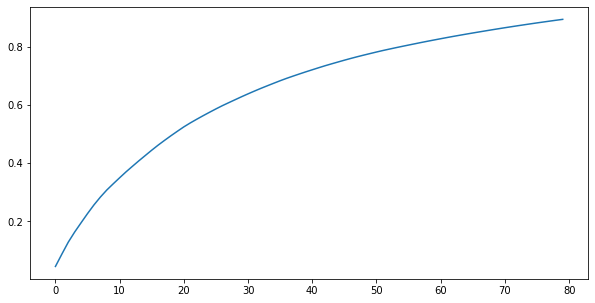

In [227]:
# Fit a PCA transformer
from sklearn.decomposition import PCA

pca = PCA(n_components=80)
pca.fit(X_train_tf)
sns.lineplot(data = pca.explained_variance_ratio_.cumsum())

In [254]:
def FE2(df, tweets, X_tf):
    
    #Apply PCA on the normalized tfidf matrix
    [Sen_compound, ORG, PERSON, LAW, EVENT, NORP] = features(tweets)
    tf = pca.transform(X_tf)
    
    #Add sentiment
    sentiment = np.array(Sen_compound).reshape(-1,1)
    
    #Give the sentiment columns five times more weights
    X = np.concatenate([tf, sentiment*5],axis=1)
    y = df['is_up']
    
    return X, y

In [246]:
X_train, y_train = FE2(df_train, t_train, X_train_tf)
X_test, y_test = FE2(df_test, t_test, X_test_tf)

# 3.2 Hyper-Parameter Tuning using Grid Search

In [255]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier


parameters = {'n_neighbors':np.arange(1, 10), 
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'manhattan']}
model = GridSearchCV(KNeighborsClassifier(), parameters, verbose=1, cv=5, n_jobs=-1, iid=True)
model.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    0.3s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid=True, n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [256]:
#CV score for each set of paramaters
model.cv_results_['mean_test_score']

array([0.52186589, 0.52186589, 0.50728863, 0.52769679, 0.52623907,
       0.54227405, 0.48688047, 0.53498542, 0.49708455, 0.52478134,
       0.50291545, 0.52623907, 0.51457726, 0.53644315, 0.48979592,
       0.51603499, 0.50437318, 0.52769679, 0.51895044, 0.51895044,
       0.5       , 0.52478134, 0.51311953, 0.53206997, 0.48833819,
       0.53061224, 0.51020408, 0.53790087, 0.50728863, 0.53498542,
       0.50145773, 0.52915452, 0.5       , 0.51749271, 0.49854227,
       0.52478134])

# 3.3 Performance on the test set

In [257]:
#Apply the model on the test set using the best parameters given by the grid search
model.score(X_test, y_test)

0.5752212389380531